In [71]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np

In [57]:
def imagenette_loader(path):
    """
    loader for the dataset if you want to load images
    as numpy arrays
    """
    img = Image.open(path, mode='r')
    # convert PIL img to numpy array
    img = np.asarray(img)
    return img

In [80]:
root_train = '../data/imagenette2-320/train'
root_val = '../data/imagenette2-320/val'
transform = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [81]:
trainset = datasets.ImageFolder(root_train, transform=transform)
valset = datasets.ImageFolder(root_val, transform=transform)
img_data = datasets.ImageFolder(root_train, loader=imagenette_loader)

In [82]:
len(img_data)

9469

In [86]:
img_data[2000][0].shape

(320, 388, 3)

In [91]:
img_data.extensions

('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

## Explore Images

There are 10 classes of images. Lets take a look at each of these classes.

The classes we consider are

In [93]:
img_data.classes, img_data.class_to_idx

(['n01440764',
  'n02102040',
  'n02979186',
  'n03000684',
  'n03028079',
  'n03394916',
  'n03417042',
  'n03425413',
  'n03445777',
  'n03888257'],
 {'n01440764': 0,
  'n02102040': 1,
  'n02979186': 2,
  'n03000684': 3,
  'n03028079': 4,
  'n03394916': 5,
  'n03417042': 6,
  'n03425413': 7,
  'n03445777': 8,
  'n03888257': 9})

These classes are names after the official imagenette convention but for simplicity we are coverting it to their common names.

In [94]:
idx_to_class = {
    0: 'tench',
    1: 'English_springer',
    2: 'cassette_player',
    3: 'chain_saw',
    4: 'church',
    5: 'French_horn',
    6: 'garbage_truck',
    7: 'gas_pump',
    8: 'golf_ball',
    9: 'parachute'
}

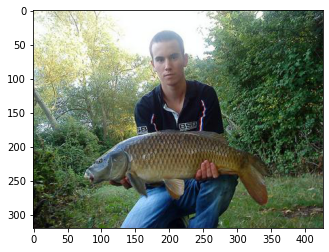

In [128]:
import matplotlib.pyplot as plt
import random

plt.imshow(img_data[6][0])
plt.show()

In [155]:
def imshow_list(indexes, idx2class):
    n = len(indexes)
    f, axarr = plt.subplots(n, 1, figsize=(10,30))
    for i,idx in enumerate(indexes):
        axarr[i].imshow(img_data[idx][0])
        axarr[i].set_title(idx2class[img_data[idx][1]])


Run this to visualize all the different classes in imagenette.

[4238, 4438, 4095, 4417, 4302, 4263, 4110, 4430]


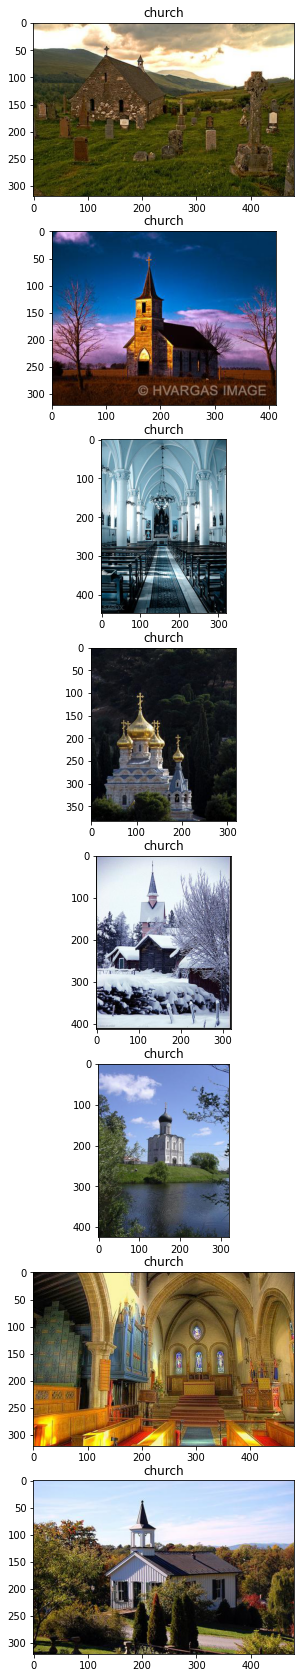

In [156]:
m = 4
idx = m*1000
idxs = list()
num = 8
for i in range(num):
    offset = random.randint(0,500)
    idxs.append(idx+offset)
    
print(idxs)
imshow_list(idxs, idx_to_class)

## AlexNet

lets train the alexnet model on this dataset to get a benchmark for the dataset. This will help us compare the other models with this.

In [261]:
from torch import nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    """
    AlexNet implementation taken from 
    https://medium.com/@smallfishbigsea/a-walk-through-of-alexnet-6cbd137a5637
    """
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 96, 11, stride=4)
        self.conv2 = nn.Conv2d(96, 256, 5, groups=2, padding=2)
        self.conv3_1 = nn.Conv2d(256, 384, 3, padding=1)
        self.conv3_2 = nn.Conv2d(384, 384, 3, groups=2, padding=1)
        self.conv4 = nn.Conv2d(384, 256, 3, groups=2, padding=1)
        
        # using the values for the alexnet paper
        self.LRN = nn.LocalResponseNorm(size=5,
                                   alpha=0.0001,
                                   beta=0.75,
                                   k=2)
        
        self.pool = nn.MaxPool2d(3, stride=2)
        self.dropout = nn.Dropout()
        
        self.fc1 = nn.Linear(256*5*5, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 1000)
        self.fc4 = nn.Linear(1000, 10)
        
    def forward(self, x):
        x = self.pool(self.LRN(F.relu(self.conv1(x))))
        x = self.pool(self.LRN(F.relu(self.conv2(x))))
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = self.pool(F.relu(self.conv4(x)))
        
        print(x.shape)
        x = self.dropout(x.view(-1, 256*5*5))
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        return x

In [254]:
class AlexNetPytorch(nn.Module):
    """
    The official PyTorch implementation of AlexNet.
    """
    def __init__(self, num_classes=1000):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [262]:
model = AlexNet()

In [264]:
from torchsummary import summary
print(summary(model, (3, 227, 227), verbose=0, col_width=13))

torch.Size([2, 256, 6, 6])
Failed to run torchsummary, printing sizes of executed layers: [Conv2d: 1-1, LocalResponseNorm: 1-2, MaxPool2d: 1-3, Conv2d: 1-4, LocalResponseNorm: 1-5, MaxPool2d: 1-6, Conv2d: 1-7, Conv2d: 1-8, Conv2d: 1-9, MaxPool2d: 1-10]


RuntimeError: shape '[-1, 6400]' is invalid for input of size 18432